In [1]:
import pickle
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from experiments import *
from utils import *

In [2]:
def plot_perf_lines(table_avg, table_std, title, xlabel, ylabel, ylim, error_bar=False):

    for method, values in table_avg.items():
        x = np.array(list(values.keys()))
        y = np.array(list(values.values()))
        s = np.array(list(table_std[method].values()))
        if error_bar: plt.errorbar(x, y, yerr=s, label=method) # , fmt='-o'
        else: plt.errorbar(x, y, label=method)
       
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim[0], ylim[1])
    plt.title(title)
    plt.legend()
    plt.grid(alpha=.3)
    #plt.show()

In [3]:
def winrate(x,axis):
    n = x.shape[axis]
    return(np.argsort(np.argsort(x, axis=axis), axis=axis)/n)

def load_scores(bench, split):
    with open(f'results/accs_{bench}_split-{split}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    
    if bench=='mmlu':
        with open(f'data/lb.pickle', 'rb') as handle:
            data2 = pickle.load(handle)
    elif bench=='alpaca':
        with open(f'data/alpaca_v2_processed.pickle', 'rb') as handle:
            data2 = pickle.load(handle)
    else:
        with open(f'data/{bench}.pickle', 'rb') as handle:
            data2 = pickle.load(handle)
    if bench=='lb':scenarios = lb_scenarios
    elif bench=='mmlu':scenarios = {'mmlu':lb_scenarios['mmlu']}
    elif bench=='helm':scenarios = helm_scenarios
    elif bench=='alpaca':scenarios = alpaca_scenarios
    else: raise NotImplementedError
    
    scenarios_position, subscenarios_position = prepare_data(scenarios, scenarios, data2)
    scores = create_responses(scenarios, scenarios, data2)
        
    balance_weights = np.ones(scores.shape[1]) #for scenario=='civil_comments', some items need to be downweighted, for other scenarios not
    if 'civil_comments' in scenarios:
        balance_weights[scenarios_position['civil_comments']] = scores[:,scenarios_position['civil_comments']].max(axis=0)
        scores[:,scenarios_position['civil_comments']] = (scores[:,scenarios_position['civil_comments']]>0).astype(float)
    if 'mmlu' in scenarios:
        N = len(scenarios_position['mmlu'])
        n_sub = len(scenarios['mmlu'])
        for sub in scenarios['mmlu']:
            n_i = len(subscenarios_position['mmlu'][sub])
            balance_weights[subscenarios_position['mmlu'][sub]] = N/(n_sub*n_i)
    scores = balance_weights*scores
    
    scores = np.vstack([scores[:,scenarios_position[scenario]].mean(axis=1) for scenario in scenarios])
    
    return scores[:,list(data.keys())]

In [4]:
methods = ['random_naive', 'anchor_naive', 'anchor-irt_naive',
           #'random_pirt', 'anchor_pirt', 'anchor-irt_pirt',
           #'random_cirt','anchor_cirt', 'anchor-irt_cirt',
           'random_gpirt', 'anchor_gpirt', 'anchor-irt_gpirt']

In [5]:
table_avg = {}
table_std = {}

In [6]:
titles = {'lb':'LLM Leaderboard','mmlu':'MMLU','helm':'HELM','alpaca':'AlpacaEval'}
ylims = {'lb':(0,.04),'helm':(0,.1),'mmlu':(0,.1),'alpaca':(0,.1)}

In [7]:
for bench in ['lb','mmlu','helm','alpaca']:
    table_avg[bench] = {}
    table_std[bench] = {}
        
    for split in ['iid', 'noniid']:
        table_avg[bench][split] = {}
        table_std[bench][split] = {}

        with open(f'results/accs_{bench}_split-{split}.pickle', 'rb') as handle:
            data = pickle.load(handle)

        models = list(data.keys())
        number_items = list(data[models[0]].keys())
        scenarios = list(data[models[0]][number_items[0]][methods[0]].keys())
        iterations = data[models[0]][number_items[0]][methods[0]][scenarios[0]]
        data = np.array([[[[data[model][number_item][method][scenario] for scenario in scenarios]  for model in data.keys()] for number_item in number_items] for method in methods])

        scores = load_scores(bench, split)
        if bench=='helm':
            data = np.abs(winrate(data, axis=2).mean(axis=3)-winrate(scores, axis=1).mean(axis=0)[None,None,:,None])
        else:
            data = np.abs(data.mean(axis=3)-scores.mean(axis=0)[None,None,:,None])
        data = data.mean(-1) #iterations
        
        
        for i,method in enumerate(methods):
            table_avg[bench][split][method] = {}
            table_std[bench][split][method] = {}

            for j,number_item in enumerate(number_items):
                table_avg[bench][split][method][number_item] = data.mean(-1)[i,j]
                table_std[bench][split][method][number_item] = data.std(-1)[i,j]

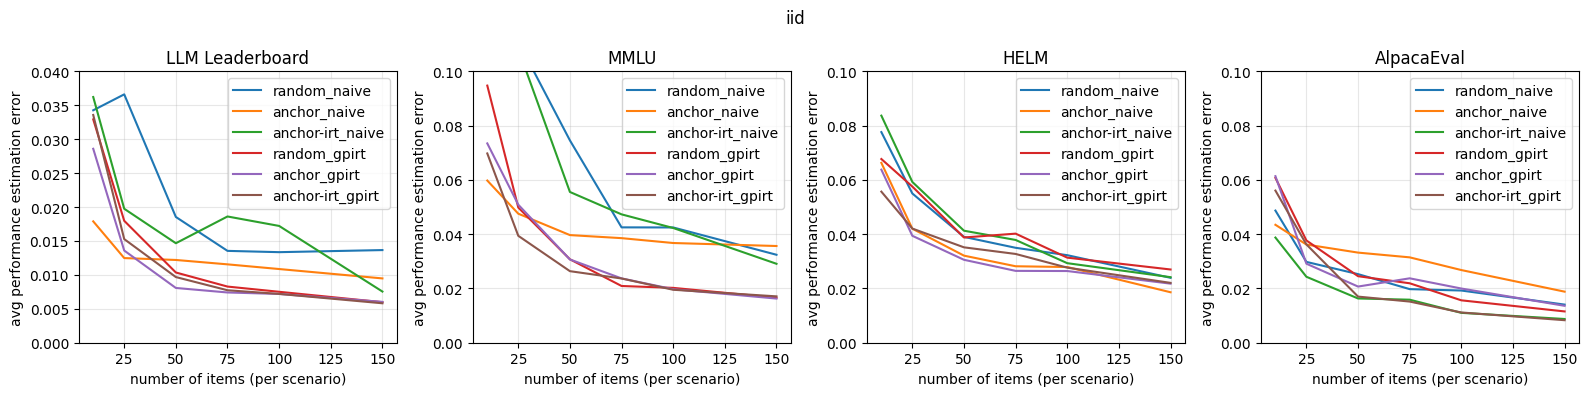

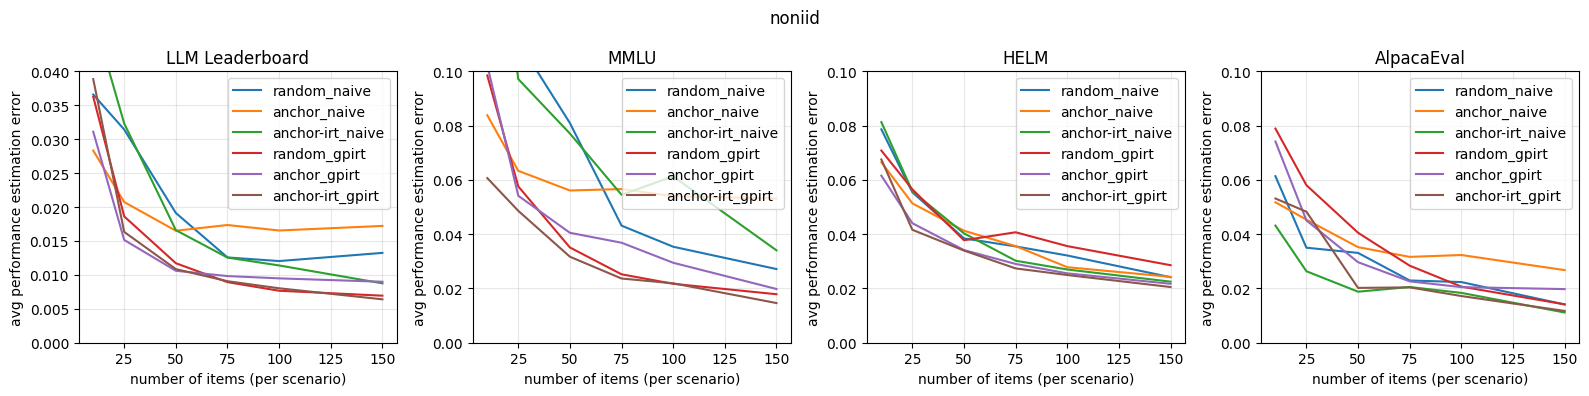

In [8]:
import matplotlib.pyplot as plt

# Number of benchmarks
num_benchmarks = 4

for split in ['iid','noniid']:
    # Create a figure and a set of subplots
    plt.figure(figsize=(16,4))

    # Iterate over your benchmarks
    for i, bench in enumerate(['lb','mmlu','helm','alpaca']):  # Replace `benchmarks` with your list of benchmarks
        # Plot on the ith subplot
        plt.subplot(1, 4, i+1)
        plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                               title=titles[bench],
                               xlabel='number of items (per scenario)',
                               ylabel='avg performance estimation error', ylim=ylims[bench], error_bar=False)

    plt.suptitle(split)
    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()


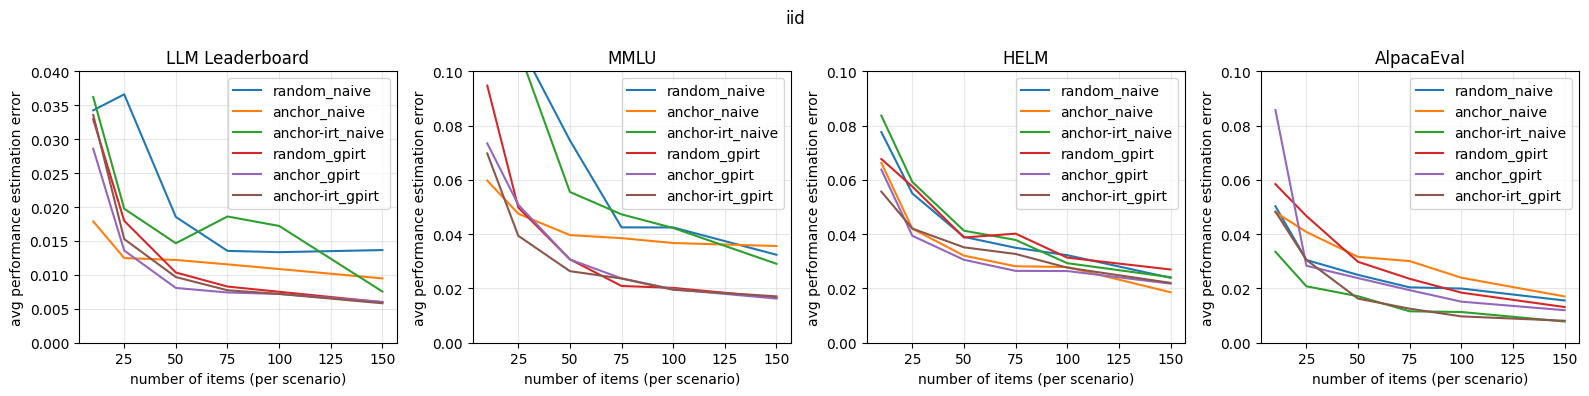

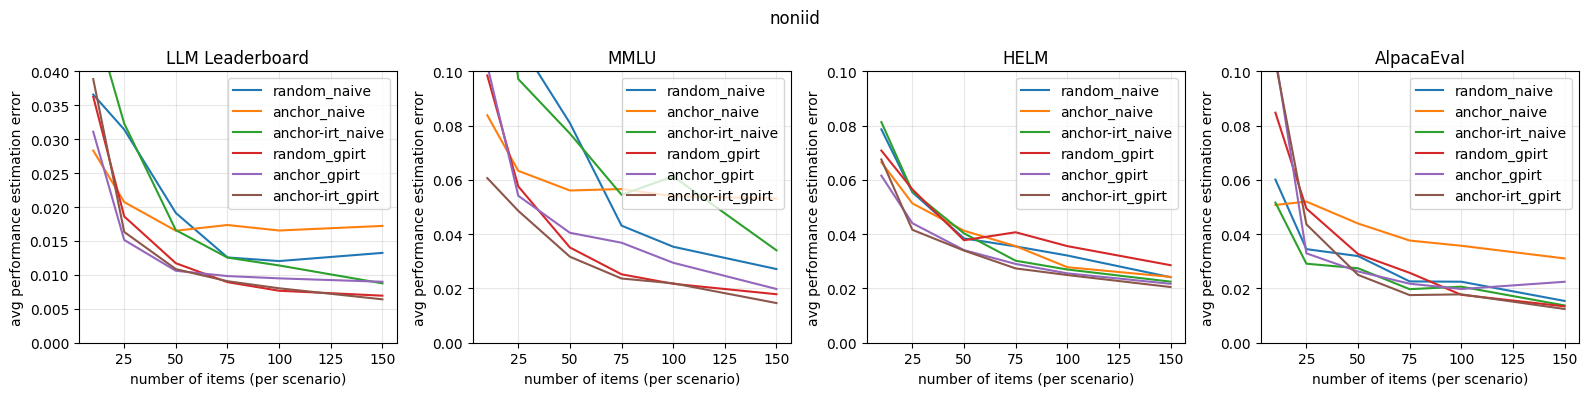

In [77]:
import matplotlib.pyplot as plt

# Number of benchmarks
num_benchmarks = 4

for split in ['iid','noniid']:
    # Create a figure and a set of subplots
    plt.figure(figsize=(16,4))

    # Iterate over your benchmarks
    for i, bench in enumerate(['lb','mmlu','helm','alpaca']):  # Replace `benchmarks` with your list of benchmarks
        # Plot on the ith subplot
        plt.subplot(1, 4, i+1)
        plot_perf_lines(table_avg[bench][split], table_std[bench][split],
                               title=titles[bench],
                               xlabel='number of items (per scenario)',
                               ylabel='avg performance estimation error', ylim=ylims[bench], error_bar=False)

    plt.suptitle(split)
    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()


In [78]:
with open('data/lb.pickle', 'rb') as handle:
    data = pickle.load(handle)